# Sistem rekomendasi tempat wisata di Indonesia menggunakan Neural Collaborative Filtering

**Collaborative Filtering (CF)** adalah teknik sistem rekomendasi yang memprediksi preferensi (rating) pengguna terhadap item berdasarkan pola interaksi pengguna dan item (tanpa melihat konten/fitur eksplisit).

Terdapat 2 pendekatan umum:
1. Memory-based CF:
    - Gunakan user-user atau item-item similarity (misal: cosine, Pearson).
    - Tidak butuh training model.
    - Contoh: "Orang yang mirip kamu menyukai film ini."

2. Model-based CF:
    - Gunakan model matematis/statistik untuk belajar representasi tersembunyi (latent factor).
    - Contoh: Matrix Factorization (SVD, ALS).


**Neural Collaborative Filtering (NCF)** adalah pengembangan dari model-based CF, yang menggantikan matrix factorization dengan neural network. NCF belajar hubungan non-linear antara user dan item melalui representasi embedding dan MLP (Multi-Layer Perceptron).

pada NCF:
- Gunakan embedding untuk user & item.
- Gunakan neural network untuk mempelajari interaksi.
- Bisa menambahkan layer non-linear (ReLU, Dropout, BatchNorm).
- Mendukung kompleksitas hubungan yang tidak bisa ditangkap oleh linear model seperti Matrix Factorization.

In [2]:
# Menyiapkan library
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

# 1. Menentukan Label Data	

Pada eksperimen ini NF mencoba memprediksi rating dari aktivitas pengguna. sehingga pendekatan yg dilakukan adalah regresi sederhanan sehingga tidak ada proses label data (anotasi).

# 2. Mengumpulkan Data	

Data diambil dari kaggel menggunakan library kaggel terkait dengan data pariwisata di indonesia. Adapun langkah-langkah dalam mengambilan data yang terdapat pada kaggel adalah: 
1. Membuka laman Kaggle.com dan memilih data yang diinginkan.
2. Kemudian import data di ke dalam phyton (google collab)

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # kaggle.json didapatkan dari setiap akun kagel

mkdir: /Users/mac/.kaggle: File exists


In [ ]:
#!/bin/bash
# !pip install kaggle
!kaggle datasets download aprabowo/indonesia-tourism-destination

Dataset URL: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination
License(s): copyright-authors
  0%|                                                | 0.00/158k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 158k/158k [00:00<00:00, 15.4MB/s]


In [ ]:
!unzip indonesia-tourism-destination.zip
!mkdir indonesia-tourism-destination
!mv  package_tourism.csv indonesia-tourism-destination/
!mv  tourism_rating.csv indonesia-tourism-destination/
!mv  tourism_with_id.csv indonesia-tourism-destination/
!mv  user.csv indonesia-tourism-destination/
!rm -rf indonesia-tourism-destination.zip

Archive:  indonesia-tourism-destination.zip
  inflating: package_tourism.csv     
  inflating: tourism_rating.csv      
  inflating: tourism_with_id.csv     
  inflating: user.csv                


# 3. Menelaah Data	

Dataset terdiri dari 3 file dengan ekstensi file <code>.csv</code>

1. <code>tourism_with_id.csv</code> - mengandung informasi tempak wisata di 5 kota besar di Indonesia (hanya kota Bandung yang dipakai)
2. <code>user.csv</code> - mengandung informasi pengguna untuk membuat rekomendasi fitur berdasar pengguna
3. <code>tourism_rating.csv</code> - mengandung informasi pengguna, tempat wisata, dan rating untuk membuat sistem rekomendasi berdasar rating

In [3]:
rating = pd.read_csv('indonesia-tourism-destination/tourism_rating.csv')
place = pd.read_csv('indonesia-tourism-destination/tourism_with_id.csv')
user = pd.read_csv('indonesia-tourism-destination/user.csv')

## 3.1. Eksplorasi data tempat wisata

In [4]:
# Eksplorasi data tempat wisata
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2


In [5]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [6]:
tempat_top_10 = place['City'].value_counts().reset_index()
tempat_top_10

,City,count
0,Yogyakarta,126
1,Bandung,124
2,Jakarta,84
3,Semarang,57
4,Surabaya,46


In [7]:
place.isnull().sum()

Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
Unnamed: 11     437
Unnamed: 12       0
dtype: int64

In [8]:
# Filter kota yogyakarta
# place_diy = place[place['City']=='Yogyakarta']
# place_diy.head(2)

# seluruh data digunakan
place_diy = place

## 3.2. Eksplorasi data rating

In [9]:
rating.head(2)

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2


In [10]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [11]:
rating.isnull().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64

In [18]:
rating_diy = pd.merge(rating, place_diy[['Place_Id']], how='right', on='Place_Id')
rating_diy.head(10)

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4
5,100,1,1
6,105,1,5
7,118,1,4
8,159,1,1
9,162,1,5


## 3.3. Eksplorasi data wisatawan (user)

In [215]:
user.head(2)

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21


In [216]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


In [217]:
user.isnull().sum()

User_Id     0
Location    0
Age         0
dtype: int64

In [34]:
user_diy = pd.merge(user, rating_diy[['User_Id']], how='right', on='User_Id').drop_duplicates().sort_values('User_Id')
user_diy.head()

,User_Id,Location,Age
83,1,"Semarang, Jawa Tengah",20
18,2,"Bekasi, Jawa Barat",21
345,3,"Cirebon, Jawa Barat",23
62,4,"Bekasi, Jawa Barat",21
63,5,"Lampung, Sumatera Selatan",20


## 3.4. Eksplorasi Data

In [24]:
top_10 = rating_diy['Place_Id'].value_counts().reset_index()[0:10]
top_10

,Place_Id,count
0,177,39
1,298,39
2,437,38
3,201,37
4,208,36
5,167,34
6,244,34
7,344,33
8,402,33
9,29,33


In [25]:
# Membuat dataframe berisi lokasi dengan jumlah rating terbanyak
top_10 = rating_diy['Place_Id'].value_counts().reset_index()[0:10]
top_10 = pd.merge(top_10, place_diy[['Place_Id','Place_Name']], how='left', on='Place_Id')
top_10

,Place_Id,count,Place_Name
0,177,39,Pantai Parangtritis
1,298,39,Gunung Lalakon
2,437,38,Gereja Perawan Maria Tak Berdosa Surabaya
3,201,37,Pantai Kesirat
4,208,36,Taman Sungai Mudal
5,167,34,Geoforest Watu Payung Turunan
6,244,34,Kampung Batu Malakasari
7,344,33,Pantai Marina
8,402,33,Food Junction Grand Pakuwon
9,29,33,Wisata Kuliner Pecenongan


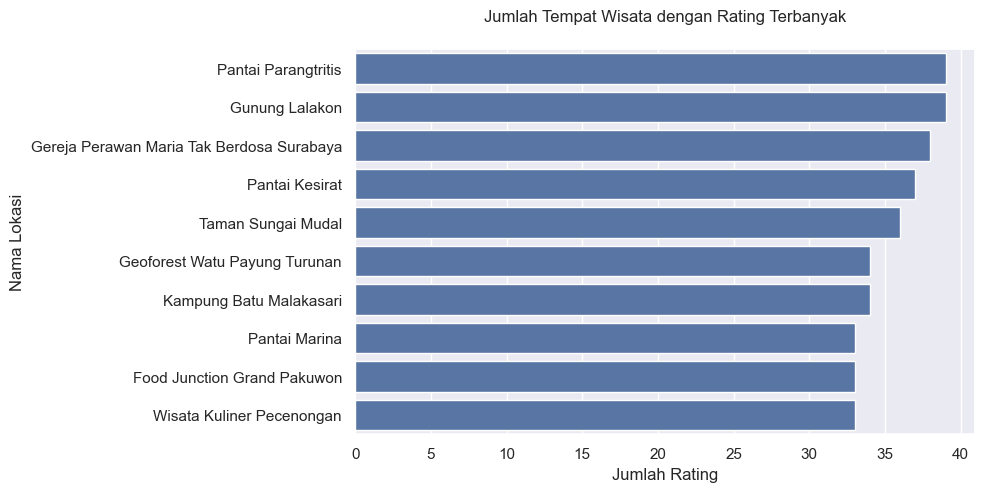

In [26]:
# Membuat visualisasi wisata dengan jumlah rating terbanyak
plt.figure(figsize=(8,5))
sns.barplot(x='count', y='Place_Name', data=top_10)
plt.title('Jumlah Tempat Wisata dengan Rating Terbanyak', pad=20)
plt.xlabel('Jumlah Rating')
plt.ylabel('Nama Lokasi')
plt.show()

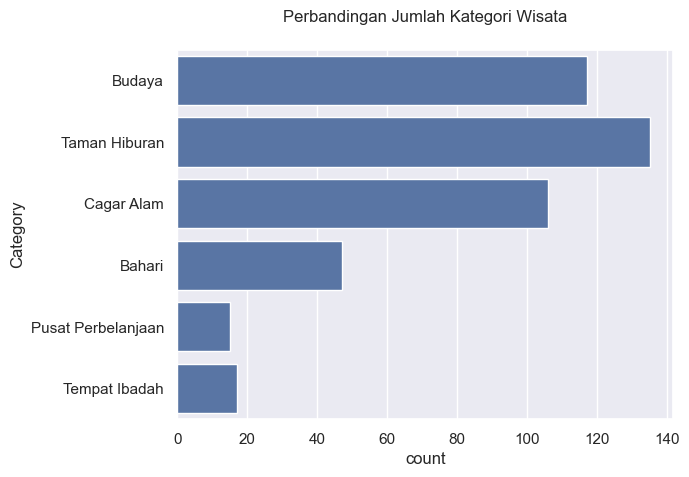

In [222]:
sns.countplot(y='Category', data=place)
plt.title('Perbandingan Jumlah Kategori Wisata', pad=20)
plt.show()

# 4. Memvalidasi Data	

proses memeriksa dan memastikan keakuratan, konsistensi, dan kelengkapan data sebelum dianalisis atau digunakan

## 4.1 data place


In [27]:
place_diy.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2


In [28]:
# Cek nilai ratting Tempat
place_rate = place_diy.Rating.tolist()
place_rate_more_than_5 = [rate for rate in place_rate if rate > 5]
print(place_rate_more_than_5)
place_rate_less_than_0 = [rate for rate in place_rate if rate < 0]
print(place_rate_less_than_0)

# Cek nilai harga
place_price = place_diy.Price.tolist()
place_price_less_than_0 = [price for rate in place_price if rate < 0]
print(place_price_less_than_0)

[]
[]
[]


In [29]:
place_diy_val = place_diy

## 4.2 data rating

In [30]:
rating_diy.head(2)

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2


In [31]:
# Menghapus data duplikat berdasarkan User_Id dan Place_Id
# Satu pengguna hanya dapat memberikan ratting pada satu tempat wisata.
rating_diy_val = rating_diy.drop_duplicates(subset=['User_Id', 'Place_Id'])
print(rating_diy.shape)
print(rating_diy_val.shape)

(10000, 3)
(9597, 3)


In [32]:
# Data hasil menghapus duplikat dari user dan place id
rating_diy_val.head(2)

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2


## 4.3 data user

In [35]:
user_diy.head(2)

,User_Id,Location,Age
83,1,"Semarang, Jawa Tengah",20
18,2,"Bekasi, Jawa Barat",21


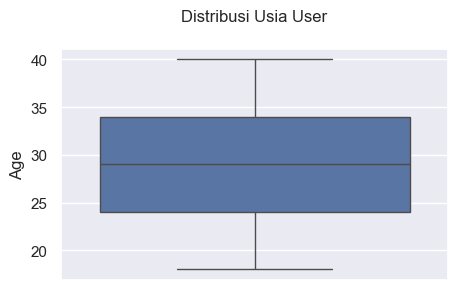

In [36]:
# Cek apakah ada data umur yang aneh
plt.figure(figsize=(5,3))
sns.boxplot(user_diy['Age']);
plt.title('Distribusi Usia User', pad=20)
plt.show()

In [37]:
user_diy_val = user_diy

# 6. Membersihkan Data	

Berdasarkan tahapan 3 terdapat beberap kolom data yang memiliki nilai NULL yang besar. Dan data tersebut tidak digunakan dalam proses mengembangan model yaitu <code>'Time_Minutes','Unnamed: 11','Unnamed: 12', 'Coordinate'</code>, maka dilakukan penghaspusan kolom

In [38]:
place_diy_new = place_diy_val.drop(['Time_Minutes','Unnamed: 11','Unnamed: 12', 'Coordinate'], axis=1)
place_diy_new.head(10)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,-6.124190,106.839134
5,6,Taman Impian Jaya Ancol,Taman Impian Jaya Ancol merupakan sebuah objek...,Taman Hiburan,Jakarta,25000,4.5,-6.117333,106.857995
6,7,Kebun Binatang Ragunan,Kebun Binatang Ragunan adalah sebuah kebun bin...,Cagar Alam,Jakarta,4000,4.5,-6.312459,106.820187
7,8,Ocean Ecopark,Ocean Ecopark Salah satu zona rekreasi Ancol y...,Taman Hiburan,Jakarta,180000,4.0,-6.125802,106.836325
8,9,Pelabuhan Marina,Pelabuhan Marina Ancol berada di kawasan Taman...,Bahari,Jakarta,175000,4.4,1.078880,103.931398
9,10,Pulau Tidung,Pulau Tidung adalah salah satu kelurahan di ke...,Bahari,Jakarta,150000,4.5,-5.803205,106.523791


In [39]:
rating_diy_new = rating_diy_val
rating_diy_new.head(10)

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4
5,100,1,1
6,105,1,5
7,118,1,4
8,159,1,1
9,162,1,5


In [40]:
user_diy_new = user_diy_val
user_diy_new.head(10)

,User_Id,Location,Age
83,1,"Semarang, Jawa Tengah",20
18,2,"Bekasi, Jawa Barat",21
345,3,"Cirebon, Jawa Barat",23
62,4,"Bekasi, Jawa Barat",21
63,5,"Lampung, Sumatera Selatan",20
64,6,"Jakarta Utara, DKI Jakarta",18
256,7,"Jakarta Selatan, DKI Jakarta",39
528,8,"Bandung, Jawa Barat",40
602,9,"Surabaya, Jawa Timur",38
241,10,"Bekasi, Jawa Barat",39


# 5. Menentukan Objek Data	

Menentukan atribut data yang akan digunakan dalam pemodelan ini adalah data interaksi antara pengguna dan tempat wisata yang direpresentasikan dengan nilai rating. Sehingga data yang digunakan adalah data <code>rating</code>

In [41]:
rating_diy_new.head(10)

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4
5,100,1,1
6,105,1,5
7,118,1,4
8,159,1,1
9,162,1,5


In [43]:
rating_diy_new.dtypes

User_Id          int64
Place_Id         int64
Place_Ratings    int64
dtype: object

# 7. Mengkonstruksi Data	

In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader

# Load dataset
df = rating_diy_new

# Encoding user & item
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['user'] = user_encoder.fit_transform(df['User_Id'])
df['item'] = item_encoder.fit_transform(df['Place_Id'])

num_users = df['user'].nunique()
num_items = df['item'].nunique()

# Train-Test split
train, test = train_test_split(df[['user', 'item', 'Place_Ratings']], test_size=0.2, random_state=42)

In [45]:
print(train.shape)
print(train.head(2))
print(test.shape)
print(test.head(2))

(7677, 3)
      user  item  Place_Ratings
5365    16   235              3
8009   136   349              4
(1920, 3)
      user  item  Place_Ratings
1373   104    59              5
9898     4   433              4


In [46]:
# Custom Dataset
class RatingDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user'].values, dtype=torch.long)
        self.items = torch.tensor(df['item'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['Place_Ratings'].values, dtype=torch.float)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

train_ds = RatingDataset(train)
test_ds = RatingDataset(test)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

# 8. Membangun Model

In [48]:
# menentukan niali seed

import random
import numpy as np

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(2025)

## 8.1 Neural Collaborative Filtering

In [49]:
import torch.nn as nn

class NCF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=64):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, emb_size)
        self.item_embedding = nn.Embedding(num_items, emb_size)

        self.mlp = nn.Sequential(
            nn.Linear(emb_size * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 1)  # regresi: output rating
        )

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        x = torch.cat([user_emb, item_emb], dim=1)
        out = self.mlp(x)
        return out.squeeze()

Training

In [50]:
model = NCF(num_users, num_items, emb_size=32)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

train_losses = []
test_losses = []

epochs = 50
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for user, item, rating in train_dl:
        pred = model(user, item)
        loss = loss_fn(pred, rating)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dl)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for user, item, rating in test_dl:
            pred = model(user, item)
            loss = loss_fn(pred, rating)
            total_val_loss += loss.item()
    
    avg_test_loss = total_val_loss / len(test_dl)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


Epoch 1/50 - Train Loss: 2.5928, Test Loss: 2.2523
Epoch 2/50 - Train Loss: 2.0869, Test Loss: 2.0525
Epoch 3/50 - Train Loss: 1.9372, Test Loss: 2.0203
Epoch 4/50 - Train Loss: 1.8767, Test Loss: 2.0389
Epoch 5/50 - Train Loss: 1.8040, Test Loss: 2.1135
Epoch 6/50 - Train Loss: 1.7323, Test Loss: 2.0644
Epoch 7/50 - Train Loss: 1.6635, Test Loss: 2.1453
Epoch 8/50 - Train Loss: 1.5932, Test Loss: 2.1552
Epoch 9/50 - Train Loss: 1.5454, Test Loss: 2.2564
Epoch 10/50 - Train Loss: 1.4892, Test Loss: 2.2947
Epoch 11/50 - Train Loss: 1.4175, Test Loss: 2.2923
Epoch 12/50 - Train Loss: 1.3563, Test Loss: 2.3168
Epoch 13/50 - Train Loss: 1.3145, Test Loss: 2.3736
Epoch 14/50 - Train Loss: 1.2504, Test Loss: 2.4418
Epoch 15/50 - Train Loss: 1.1714, Test Loss: 2.3678
Epoch 16/50 - Train Loss: 1.1691, Test Loss: 2.4006
Epoch 17/50 - Train Loss: 1.1093, Test Loss: 2.4138
Epoch 18/50 - Train Loss: 1.0813, Test Loss: 2.4440
Epoch 19/50 - Train Loss: 1.0331, Test Loss: 2.4237
Epoch 20/50 - Train L

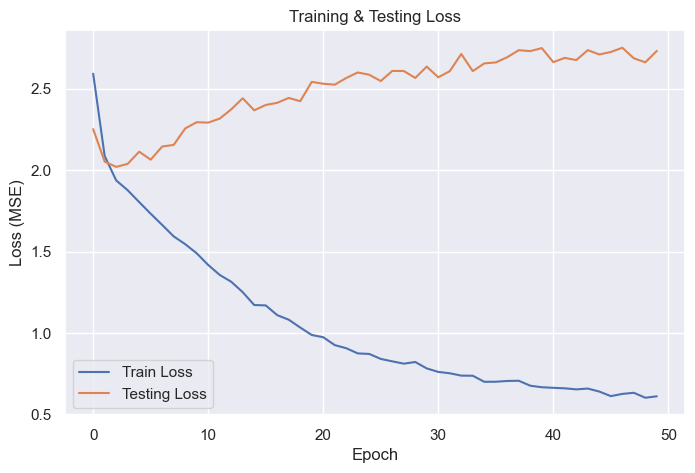

In [51]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Testing Loss')
plt.legend()
plt.grid(True)
plt.show()

Early stopping

In [52]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [53]:
model = NCF(num_users, num_items, emb_size=32)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
early_stopping = EarlyStopping(patience=5, delta=0.01)

train_losses = []
test_losses = []

epochs = 50
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for user, item, rating in train_dl:
        pred = model(user, item)
        loss = loss_fn(pred, rating)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dl)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for user, item, rating in test_dl:
            pred = model(user, item)
            loss = loss_fn(pred, rating)
            total_val_loss += loss.item()
    
    avg_test_loss = total_val_loss / len(test_dl)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    early_stopping(avg_test_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break


Epoch 1/50 - Train Loss: 2.7407, Test Loss: 2.2127
Epoch 2/50 - Train Loss: 2.1134, Test Loss: 2.1141
Epoch 3/50 - Train Loss: 1.9714, Test Loss: 2.2101
Epoch 4/50 - Train Loss: 1.8845, Test Loss: 2.1257
Epoch 5/50 - Train Loss: 1.7996, Test Loss: 2.1149
Epoch 6/50 - Train Loss: 1.7271, Test Loss: 2.1472
Epoch 7/50 - Train Loss: 1.6905, Test Loss: 2.2310
Early stopping


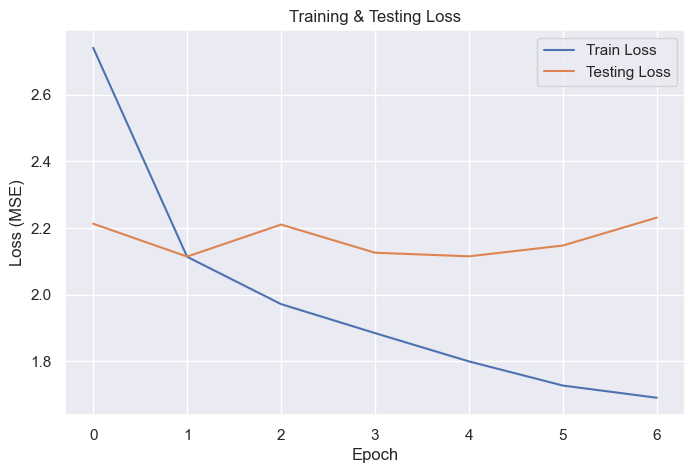

In [55]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Testing Loss')
plt.legend()
plt.grid(True)
plt.show()

## 8.2 MF

In [56]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super(MatrixFactorization, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)  # P matrix
        self.item_factors = nn.Embedding(n_items, n_factors)  # Q matrix

    def forward(self, user, item):
        user_vec = self.user_factors(user)
        item_vec = self.item_factors(item)
        return (user_vec * item_vec).sum(1)  # dot product


Training

In [57]:
model_mf = MatrixFactorization(num_users, num_items, n_factors=32)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_mf.parameters(), lr=0.01)

train_losses_mf = []
test_losses_mf = []

epochs = 10
for epoch in range(epochs):
    model_mf.train()
    total_train_loss = 0
    for user, item, rating in train_dl:
        pred = model_mf(user, item)
        loss = loss_fn(pred, rating)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dl)
    train_losses_mf.append(avg_train_loss)

    # Validation loss
    model_mf.eval()
    total_val_loss = 0
    with torch.no_grad():
        for user, item, rating in test_dl:
            pred = model_mf(user, item)
            loss = loss_fn(pred, rating)
            total_val_loss += loss.item()
    
    avg_test_loss = total_val_loss / len(test_dl)
    test_losses_mf.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_test_loss:.4f}")

Epoch 1/10 - Train Loss: 40.2509, Val Loss: 38.3663
Epoch 2/10 - Train Loss: 22.8026, Val Loss: 34.6692
Epoch 3/10 - Train Loss: 14.0858, Val Loss: 32.8062
Epoch 4/10 - Train Loss: 9.0500, Val Loss: 31.8375
Epoch 5/10 - Train Loss: 5.9761, Val Loss: 31.3506
Epoch 6/10 - Train Loss: 4.0045, Val Loss: 31.2342
Epoch 7/10 - Train Loss: 2.7004, Val Loss: 31.1766
Epoch 8/10 - Train Loss: 1.8177, Val Loss: 31.2309
Epoch 9/10 - Train Loss: 1.2303, Val Loss: 31.3065
Epoch 10/10 - Train Loss: 0.8281, Val Loss: 31.4177


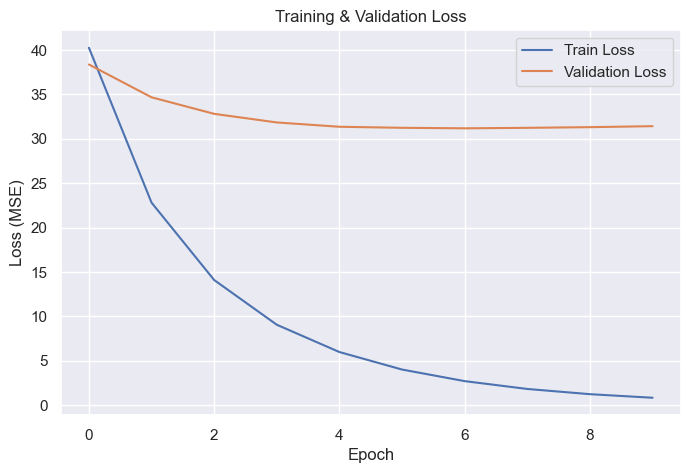

In [58]:
plt.figure(figsize=(8,5))
plt.plot(train_losses_mf, label='Train Loss')
plt.plot(test_losses_mf, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 8.3. Comparison

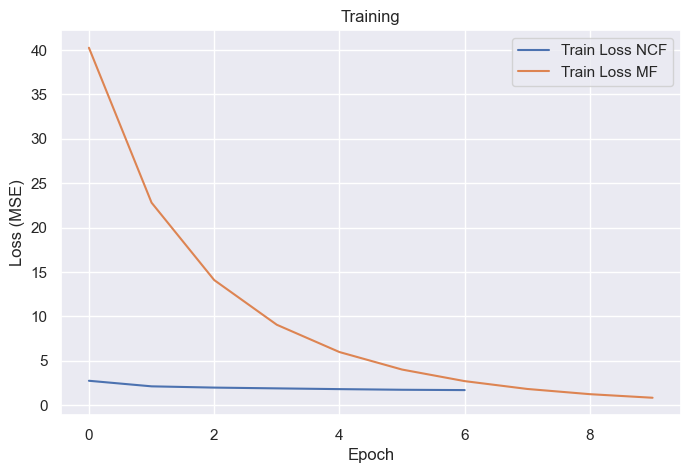

In [59]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss NCF')
plt.plot(train_losses_mf, label='Train Loss MF')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training')
plt.legend()
plt.grid(True)
plt.show()

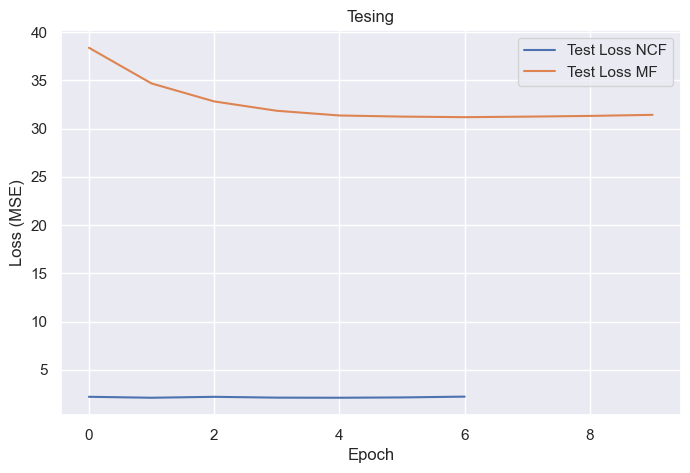

In [60]:
plt.figure(figsize=(8,5))
plt.plot(test_losses, label='Test Loss NCF')
plt.plot(test_losses_mf, label='Test Loss MF')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Tesing')
plt.legend()
plt.grid(True)
plt.show()

# 9. Mengevaluasi Hasil Pemodelan	

RMSE mengukur:
- Seberapa jauh prediksi model dari nilai sebenarnya, dalam satuan yang sama dengan target (misalnya: rating 1–5).
- Penalti lebih besar terhadap prediksi yang jauh dari nilai aktual (karena kuadrat error).

MAE mengukur:
- Kesalahan rata-rata dalam satuan aslinya
- Seberapa besar kesalahan prediksi model secara umum
- Semua kesalahan diperlakukan sama (tidak mengkuadratkan error)

## 9.1. Neural Collaborative Filtering (NFC)

In [61]:
early_stopping.load_best_model(model)

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.eval()
preds, targets = [], []

with torch.no_grad():
    for user, item, rating in test_dl:
        pred = model(user, item)
        preds.extend(pred.tolist())
        targets.extend(rating.tolist())

mse = mean_squared_error(targets, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(targets, preds)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

Test RMSE: 1.4937
Test MAE : 1.2696


## 9.2. MF

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model_mf.eval()
preds, targets = [], []

with torch.no_grad():
    for user, item, rating in test_dl:
        pred = model_mf(user, item)
        preds.extend(pred.tolist())
        targets.extend(rating.tolist())

mse = mean_squared_error(targets, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(targets, preds)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")


Test RMSE: 5.6052
Test MAE : 4.4255


## 9.3 Simpan model

In [64]:
# Neural Collaborative Filtering (NFC)
torch.save(model.state_dict(), "model/ncf_model.pth")

# 10. Deployment

In [65]:
from fastapi import FastAPI
from pydantic import BaseModel
import torch
import torch.nn as nn
import pandas as pd

app = FastAPI()

model = NCF(num_users, num_items, emb_size=32)
model.load_state_dict(torch.load("model/ncf_model.pth", map_location='cpu'))
model.eval()

NCF(
  (user_embedding): Embedding(300, 32)
  (item_embedding): Embedding(437, 32)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [66]:
class UserInput(BaseModel):
    user_id: int
    top_k: int = 10

In [67]:
@app.post("/recommend/")
def recommend(input: UserInput):
    if input.user_id not in user2idx:
        return {"error": "Unknown user_id"}

    user_idx = torch.tensor([user2idx[input.user_id]] * n_items)
    item_idx = torch.tensor(list(range(n_items)))

    with torch.no_grad():
        scores = model(user_idx, item_idx)

    top_k_idx = torch.topk(scores, input.top_k).indices
    recommended_items = [int(idx2item[i.item()]) for i in top_k_idx]

    return {
        "user_id": input.user_id,
        "recommended_movie_ids": recommended_items
    }


In [381]:
# !uvicorn main:app --reload

In [379]:
!curl -X POST http://127.0.0.1:8000/recommend/ \
    -H "Content-Type: application/json" \
    -d '{"user_id": 1, "top_k": 5}'


curl: (7) Failed to connect to 127.0.0.1 port 8000 after 8 ms: Couldn't connect to server
